**Import Libraries**

In [1]:
pip install lightly mambavision transformers mamba_ssm timm

  Using cached mambavision-1.0.9-py3-none-any.whl.metadata (13 kB)
  Using cached timm-0.9.0-py3-none-any.whl.metadata (68 kB)
  Using cached mamba_ssm-1.0.1.tar.gz (28 kB)
  Preparing metadata (setup.py) ... done
  Using cached causal_conv1d-1.0.2.tar.gz (6.4 kB)
  Preparing metadata (setup.py) ... done
  Using cached buildtools-1.0.6-py3-none-any.whl
  Using cached sqlalchemy-2.0.39-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.6 kB)
  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached twisted-24.11.0-py3-none-any.whl.metadata (20 kB)
  Using cached simplejson-3.20.1-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.2 kB)
  Using cached furl-2.1.4-py2.py3-none-any.whl.metadata (25 kB)
  Using cached docopt-0.6.2-py2.py3-none-any.whl
  Using cached redo-3.0.0-py2.py3-none-any.whl.metadata (8.0 kB)
  Using cached orderedmultidict-1.0.1-py2.py3-none-any.whl.metadata (1.3 k

In [2]:
# Standard Libraries
import os
import copy
import random
from glob import glob
from PIL import Image

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score

# Hugging Face transformers to load the MambaVision model
from transformers import AutoModel

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Define Parameters**

In [3]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# Parameters training
LEARNING_RATE = 0.001
LEARNING_RATE_FINE_TUNING = 0.0001
EPOCHS = 3
EPOCHS_FINE_TUNING = 100
BATCH_SIZE = 32

# Parameters early stopping
EARLY_STOPPING_PATIENCE = 10

# Parameters learning rate scheduler
LEARNING_RATE_SCHEDULER_PATIENCE = 5
LEARNING_RATE_SCHEDULER_MODE = 'min'
LEARNING_RATE_SCHEDULER_FACTOR = 0.1

# Other parameters
SEED = 42
NUM_WORKERS = 64

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [4]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data**

In [5]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Extract ChestX-ray14 dataset
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [6]:
def load_labels(csv_path, extracted_path):
    """
    Read labels from CSV, maps images to paths, and create binary disease labels.
    """

    # Read the CSV containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create binary column for 'No Finding'
    labels_df['No Finding'] = labels_df['Finding Labels'].str.contains('No Finding').astype(int)

    # Map images to their full path
    labels_df['Path'] = labels_df['Image Index'].map(
        {os.path.basename(path): path for path in glob(os.path.join(extracted_path, '**', 'images', '*.png'))}
    )
    
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Split Dataset**

In [7]:
# Split based on patients
unique_patients = df['Patient ID'].unique()

# Split patients into training, validation and test sets
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.125, random_state=SEED
)

# Create dataframes for training, validation, and test sets
train_df = df[df['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = df[df['Patient ID'].isin(val_patients)].reset_index(drop=True)
test_df = df[df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 78614
Validation size: 11212
Test size: 22294


**Define Dataset for Chest X-ray images**

In [8]:
class ChestXrayDataset(Dataset):
    """
    Create dataset for Chest X-ray images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        # Get image and labels
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformation on image
        image = self.transform(image)
        
        return image, label

**Define Data Transformations**

In [9]:
# Define transformations for training data
train_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize(224),

    # Apply random horizontal flip
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image with ±10 degrees
    transforms.RandomRotation(10),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize(224),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Create Datasets**

In [10]:
train_dataset = ChestXrayDataset(train_df, transform=train_transforms)
val_dataset = ChestXrayDataset(val_df, transform=test_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Create DataLoaders**

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# **Step 3: Build the Model**

**Initialize the Multi-Label Classifier Model**

In [12]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using Swin Transformer as the base model.
    """
    def __init__(self, num_classes=len(disease_labels), model_name="nvidia/MambaVision-T2-1K"):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained Vision Mamba model
        self.base_model = AutoModel.from_pretrained(model_name, trust_remote_code=True)

        # Replace the classification head to match the number of disease labels
        self.base_model.model.head = nn.Linear(self.base_model.model.head.in_features, num_classes)

    def forward(self, x):
        avg_pool, _ = self.base_model(x)
        return self.base_model.model.head(avg_pool)

# Initialize the Model
model = MultiLabelClassifier()
model.to(device)

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


MultiLabelClassifier(
  (base_model): MambaVisionModel(
    (model): MambaVision(
      (patch_embed): PatchEmbed(
        (proj): Identity()
        (conv_down): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(32, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (4): BatchNorm2d(80, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (levels): ModuleList(
        (0): MambaVisionLayer(
          (blocks): ModuleList(
            (0): ConvBlock(
              (conv1): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (act1): GELU(approximate='tanh')
              (conv2): Conv2

**Use Multiple GPUs**

In [13]:
model = nn.DataParallel(model)

# **Step 4: Train the Model**

**Step 1: Train Classification Head Only**

In [14]:
# First, freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last 10 parameters
named_params = list(model.named_parameters())
for name, param in named_params[-10:]:
    param.requires_grad = True

In [15]:
# Initialize loss function
criterion = nn.BCEWithLogitsLoss()

# Initialize optimizer
optimizer_head = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

# Initialize scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_head, factor=LEARNING_RATE_SCHEDULER_FACTOR, patience=LEARNING_RATE_SCHEDULER_PATIENCE, mode=LEARNING_RATE_SCHEDULER_MODE)

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    # Early stopping parameters
    best_score = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)

        # Update the scheduler
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

        # Early stopping
        if mean_auc > best_score:
            best_score = mean_auc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"New best model saved with Mean Validation AUC: {mean_auc:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping. No improvement for {patience} epochs")
                
    # Load the best model
    model.load_state_dict(torch.load('best_model.pt', weights_only=True))

    return train_losses, val_losses, val_aucs

# Train the model
train_losses_1, val_losses_1, val_aucs_1 = train_model(model, train_loader, val_loader, criterion, optimizer_head, EARLY_STOPPING_PATIENCE, EPOCHS)

Epoch 1/3: 100%|██████████| 351/351 [00:09<00:00, 37.30it/s, Loss=0.148] 


Epoch 1/3 | Training Loss: 0.1805 | Validation Loss: 0.1681 | Mean Validation AUC: 0.7308
New best model saved with Mean Validation AUC: 0.7308


Epoch 2/3: 100%|██████████| 351/351 [00:09<00:00, 37.22it/s, Loss=0.136] 


Epoch 2/3 | Training Loss: 0.1693 | Validation Loss: 0.1636 | Mean Validation AUC: 0.7469
New best model saved with Mean Validation AUC: 0.7469


Epoch 3/3: 100%|██████████| 351/351 [00:09<00:00, 37.16it/s, Loss=0.13]  


Epoch 3/3 | Training Loss: 0.1679 | Validation Loss: 0.1629 | Mean Validation AUC: 0.7497
New best model saved with Mean Validation AUC: 0.7497


**Step 2: Fine Tune Entire Network**

In [17]:
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

In [18]:
# Initialize optimizer
optimizer_full = optim.Adam(model.parameters(), lr=LEARNING_RATE_FINE_TUNING)

# Initialize scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_full, factor=LEARNING_RATE_SCHEDULER_FACTOR, patience=LEARNING_RATE_SCHEDULER_PATIENCE, mode=LEARNING_RATE_SCHEDULER_MODE)

In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    # Early stopping parameters
    best_score = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)

        # Update the scheduler
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

        # Early stopping
        if mean_auc > best_score:
            best_score = mean_auc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"New best model saved with Mean Validation AUC: {mean_auc:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping. No improvement for {patience:.4f} epochs")
                break

    # Load the best model
    model.load_state_dict(torch.load('best_model.pt', weights_only=True))

    return train_losses, val_losses, val_aucs

# Train the model for the desired number of epochs
train_losses_2, val_losses_2, val_aucs_2 = train_model(model, train_loader, val_loader, criterion, optimizer_full, EARLY_STOPPING_PATIENCE, EPOCHS_FINE_TUNING)

Epoch 1/100: 100%|██████████| 351/351 [00:09<00:00, 36.95it/s, Loss=0.118] 


Epoch 1/100 | Training Loss: 0.1594 | Validation Loss: 0.1488 | Mean Validation AUC: 0.8148
New best model saved with Mean Validation AUC: 0.8148


Epoch 2/100: 100%|██████████| 351/351 [00:09<00:00, 37.40it/s, Loss=0.0998]


Epoch 2/100 | Training Loss: 0.1507 | Validation Loss: 0.1455 | Mean Validation AUC: 0.8280
New best model saved with Mean Validation AUC: 0.8280


Epoch 3/100: 100%|██████████| 351/351 [00:09<00:00, 37.30it/s, Loss=0.105] 


Epoch 3/100 | Training Loss: 0.1469 | Validation Loss: 0.1455 | Mean Validation AUC: 0.8308
New best model saved with Mean Validation AUC: 0.8308


Epoch 4/100: 100%|██████████| 351/351 [00:09<00:00, 36.96it/s, Loss=0.105] 


Epoch 4/100 | Training Loss: 0.1439 | Validation Loss: 0.1442 | Mean Validation AUC: 0.8388
New best model saved with Mean Validation AUC: 0.8388


Epoch 5/100: 100%|██████████| 351/351 [00:09<00:00, 37.30it/s, Loss=0.116] 


Epoch 5/100 | Training Loss: 0.1411 | Validation Loss: 0.1433 | Mean Validation AUC: 0.8407
New best model saved with Mean Validation AUC: 0.8407


Epoch 6/100: 100%|██████████| 351/351 [00:10<00:00, 35.01it/s, Loss=0.106] 


Epoch 6/100 | Training Loss: 0.1385 | Validation Loss: 0.1428 | Mean Validation AUC: 0.8432
New best model saved with Mean Validation AUC: 0.8432


Epoch 7/100: 100%|██████████| 351/351 [00:09<00:00, 37.78it/s, Loss=0.113] 


Epoch 7/100 | Training Loss: 0.1359 | Validation Loss: 0.1443 | Mean Validation AUC: 0.8394


Epoch 8/100: 100%|██████████| 351/351 [00:09<00:00, 37.45it/s, Loss=0.119] 


Epoch 8/100 | Training Loss: 0.1332 | Validation Loss: 0.1445 | Mean Validation AUC: 0.8414


Epoch 9/100: 100%|██████████| 351/351 [00:09<00:00, 35.98it/s, Loss=0.111] 


Epoch 9/100 | Training Loss: 0.1301 | Validation Loss: 0.1450 | Mean Validation AUC: 0.8398


Epoch 10/100: 100%|██████████| 351/351 [00:09<00:00, 38.65it/s, Loss=0.128] 


Epoch 10/100 | Training Loss: 0.1271 | Validation Loss: 0.1489 | Mean Validation AUC: 0.8339


Epoch 11/100: 100%|██████████| 351/351 [00:10<00:00, 34.96it/s, Loss=0.114] 


Epoch 11/100 | Training Loss: 0.1237 | Validation Loss: 0.1484 | Mean Validation AUC: 0.8313


Epoch 12/100: 100%|██████████| 351/351 [00:09<00:00, 37.71it/s, Loss=0.118] 


Epoch 12/100 | Training Loss: 0.1200 | Validation Loss: 0.1493 | Mean Validation AUC: 0.8306


Epoch 13/100: 100%|██████████| 351/351 [00:09<00:00, 37.88it/s, Loss=0.115] 


Epoch 13/100 | Training Loss: 0.1079 | Validation Loss: 0.1559 | Mean Validation AUC: 0.8194


Epoch 14/100: 100%|██████████| 351/351 [00:09<00:00, 36.99it/s, Loss=0.12]  


Epoch 14/100 | Training Loss: 0.1038 | Validation Loss: 0.1594 | Mean Validation AUC: 0.8158


Epoch 15/100: 100%|██████████| 351/351 [00:09<00:00, 37.67it/s, Loss=0.121] 


Epoch 15/100 | Training Loss: 0.1014 | Validation Loss: 0.1633 | Mean Validation AUC: 0.8074


Epoch 16/100: 100%|██████████| 351/351 [00:09<00:00, 37.73it/s, Loss=0.124] 


Epoch 16/100 | Training Loss: 0.1001 | Validation Loss: 0.1635 | Mean Validation AUC: 0.8095
Early stopping. No improvement for 10.0000 epochs


# **Step 5: Evaluate the Model**

**Test-time Augmentations**

In [20]:
tta_transforms = [
    lambda img: img,
    lambda img: transforms.RandomHorizontalFlip(p=1.0)(img),
    lambda img: transforms.RandomRotation(10)(img)
]

**Evaluate the Model**

In [21]:
def evaluate_model(model, test_loader):
    """
    Evaluates the model on the test set and returns predictions and true labels.
    """
    model.eval()
    all_preds = []
    all_labels = []

    # Progress bar
    progress_bar = tqdm(test_loader, desc="Evaluating on Test Set")

    # Disable gradients for evaluation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)

            tta_preds = []
            
            # Apply each TTA transformation and predict
            for tta in tta_transforms:
                augmented_inputs = tta(inputs)
                outputs = model(augmented_inputs)
                preds = torch.sigmoid(outputs)
                tta_preds.append(preds)

            # Average the predictions across TTA transforms
            avg_preds = torch.stack(tta_preds).mean(dim=0).cpu()

            # Store predictions and true labels
            all_preds.append(avg_preds)
            all_labels.append(labels)

    # Concatenate all batches
    preds = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    return preds, labels

# Get predictions and true labels
preds, labels = evaluate_model(model, test_loader)

Evaluating on Test Set:   0%|          | 0/697 [00:00<?, ?it/s]

Evaluating on Test Set: 100%|██████████| 697/697 [00:32<00:00, 21.55it/s]


**Compute Metrics for Each Label**

In [22]:
# Initialize dictionaries for metrics
accuracy_per_label = {}
f1_per_label = {}
roc_auc_per_label = {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):
    
    # Binarize predictions with threshold 0.5
    binary_preds = preds[:, i] > 0.5

    # Calculate accuracy
    acc = accuracy_score(labels[:, i], binary_preds)

    # Calculate f1 score
    f1 = f1_score(labels[:, i], binary_preds, average='macro')

    # Calculate ROC AUC
    roc_auc = roc_auc_score(labels[:, i], preds[:, i])

    # Store metrics
    accuracy_per_label[label] = acc
    f1_per_label[label] = f1
    roc_auc_per_label[label] = roc_auc

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'F1 Score': f1_per_label,
    'ROC AUC': roc_auc_per_label
})

# Calculate the mean for all diseases
metrics_df.loc['Overall'] = metrics_df.mean()

# Print dataframe with metrics
metrics_df

,Accuracy,F1 Score,ROC AUC
Atelectasis,0.903875,0.587415,0.818575
Consolidation,0.957343,0.489103,0.820187
Infiltration,0.813313,0.557707,0.721323
Pneumothorax,0.955145,0.544446,0.887974
Edema,0.979142,0.517315,0.894203
Emphysema,0.976047,0.608079,0.923365
Fibrosis,0.983718,0.498636,0.811308
Effusion,0.900556,0.674494,0.882770
Pneumonia,0.986813,0.496681,0.753005
Pleural_Thickening,0.970261,0.492453,0.812428


**Plot ROC curves for each label**

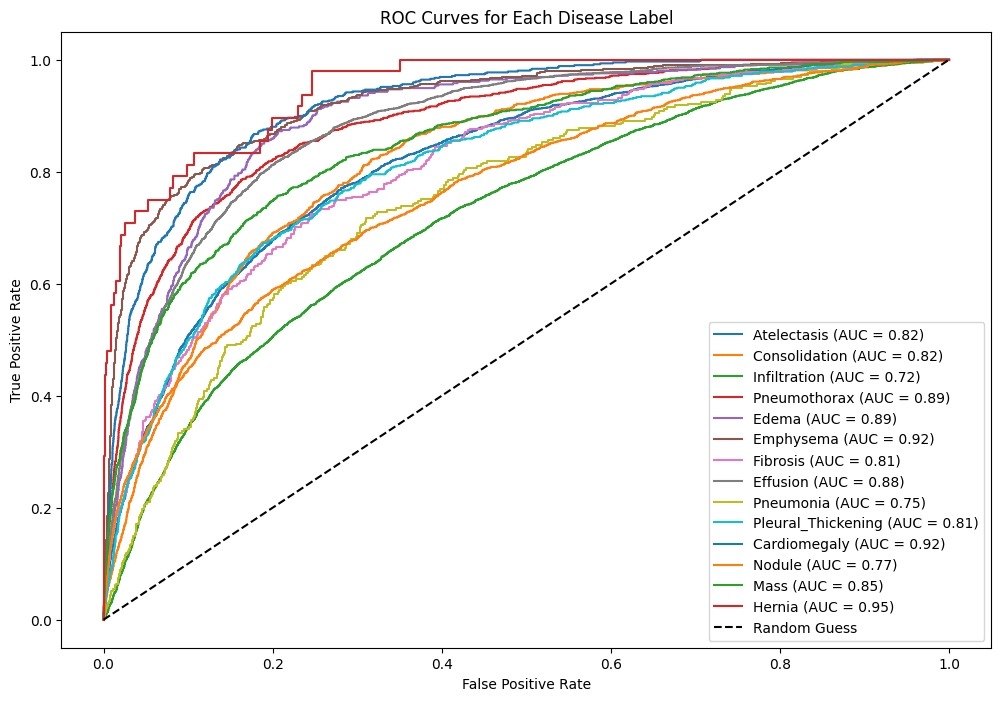

In [23]:
# Plot ROC curves
plt.figure(figsize=(12, 8))
for i, label in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(labels[:, i], preds[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_per_label[label]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Disease Label')
plt.legend(loc='lower right')
plt.show()

**Plot Training and Validation Loss**

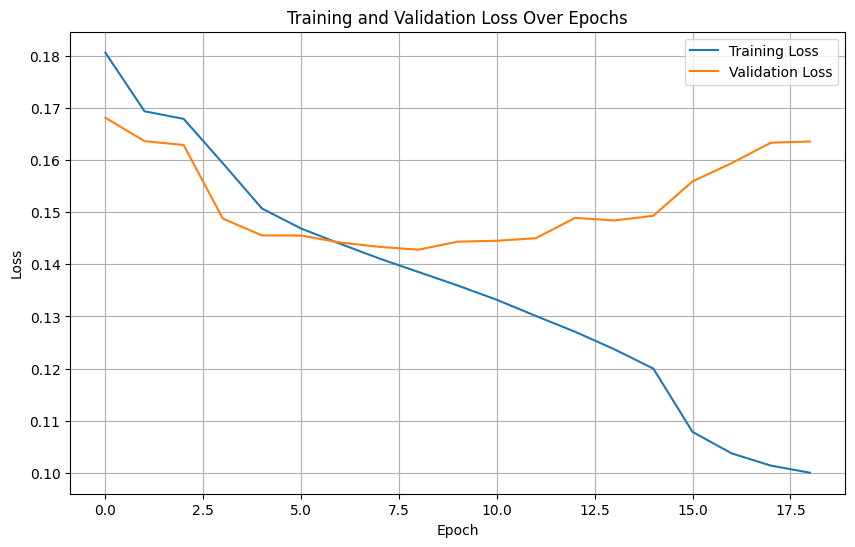

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_1 + train_losses_2, label='Training Loss')
plt.plot(val_losses_1 + val_losses_2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Training and Validation Loss only Fine-tuning**

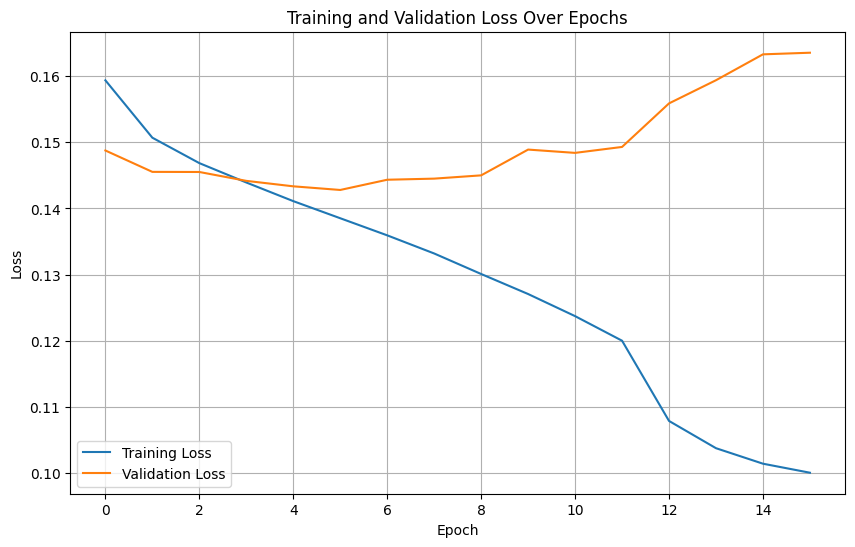

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_2, label='Training Loss')
plt.plot(val_losses_2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC**

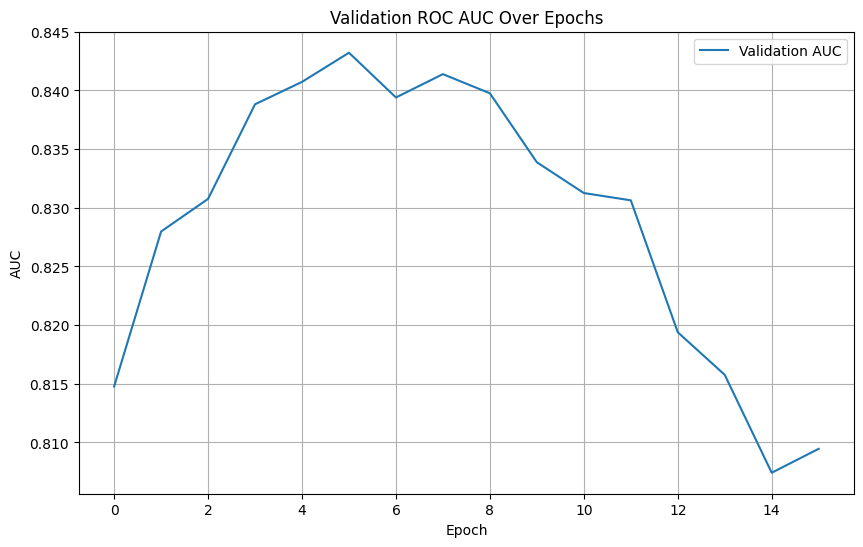

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs_2, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC only Fine-tuning**

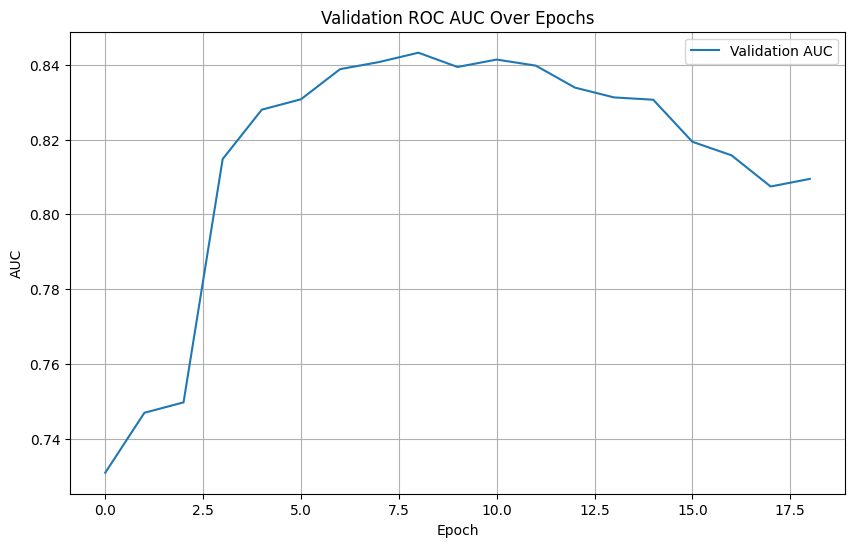

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs_1 + val_aucs_2, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()